<h1 align=center><font size = 5>Exploratory Data Analysis: Education Data from Foursquare API</font></h1>

## Introduction

In this notebook, we conduct an Exploratory Data Analysis (EDA) of the data from the Foutsquare API, especially those related to the topics of Education and EdTech. The idea is to better understand what type of data are available on Foursquare API about schools, college, university, training centers, etc and how we can use these data to develop predictive or prescriptive models.
Foursquare being a geo dataset, the analysis will mainly revolve around geographical analysis and Data Visualization on maps. Our area of investigation will focus on the educational situation in France. 

Our EDA approach follows the **Data Science Methodology CRISP-DM**. For more info about this approach, check this [Wikipedia page](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining)

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

First let's download all the libraries required for this notebook.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup # library for web parsing 

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
import urllib.request
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

from lxml.html import fromstring

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  23.89 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  36.90 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  47.51 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  35.79 MB/s
vincent-0.4.4- 100% |###################

## 1. Data Collection

#### Define Foursquare Credentials and Version

In [2]:
CLIENT_ID = '1WWXCIS2F3IUWK01JHKKKJYCU1VDZDAOC52JOLFUE35NRK2M' #  Foursquare ID
CLIENT_SECRET = '4X1X0PXTZENNVWF3LPONZJ1GPMQQ0G1QNC1DGGMSHP53SPW3' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1WWXCIS2F3IUWK01JHKKKJYCU1VDZDAOC52JOLFUE35NRK2M
CLIENT_SECRET:4X1X0PXTZENNVWF3LPONZJ1GPMQQ0G1QNC1DGGMSHP53SPW3


#### Get the list of Venue Categories 

According to Foursquare API documentation, each place (called Venue) are associated to a finite list of categories. The full list is available [here](https://developer.foursquare.com/docs/resources/categories).

Foursquare offers a dedicated endpoint to [Get Venue Categories](https://developer.foursquare.com/docs/api/venues/categories). This endpoint returns the list of categories in JSON format.

First, we create the GET request URL.

In [49]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
url

'https://api.foursquare.com/v2/venues/categories?client_id=1WWXCIS2F3IUWK01JHKKKJYCU1VDZDAOC52JOLFUE35NRK2M&client_secret=4X1X0PXTZENNVWF3LPONZJ1GPMQQ0G1QNC1DGGMSHP53SPW3&v=20180605'

We then send the GET request and examine the results.

In [50]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c91fd981ed219272e301ad5'},
 'response': {'categories': [{'categories': [{'categories': [],
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
       'suffix': '.png'},
      'id': '56aa371be4b08b9a8d5734db',
      'name': 'Amphitheater',
      'pluralName': 'Amphitheaters',
      'shortName': 'Amphitheater'},
     {'categories': [],
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
       'suffix': '.png'},
      'id': '4fceea171983d5d06c3e9823',
      'name': 'Aquarium',
      'pluralName': 'Aquariums',
      'shortName': 'Aquarium'},
     {'categories': [],
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/arcade_',
       'suffix': '.png'},
      'id': '4bf58dd8d48988d1e1931735',
      'name': 'Arcade',
      'pluralName': 'Arcades',
      'shortName': 'Arcade'},
     {'categories': [],
      'icon': {'prefix': 'https://ss3

We convert the JSON response into a dataframe with the 10 main categories of venues.

In [5]:
category = results['response']['categories']
category_list = json_normalize(category) # flatten JSON
category_list

,categories,icon.prefix,icon.suffix,id,name,pluralName,shortName
0,"[{'pluralName': 'Amphitheaters', 'id': '56aa37...",https://ss3.4sqi.net/img/categories_v2/arts_en...,.png,4d4b7104d754a06370d81259,Arts & Entertainment,Arts & Entertainment,Arts & Entertainment
1,"[{'pluralName': 'College Academic Buildings', ...",https://ss3.4sqi.net/img/categories_v2/educati...,.png,4d4b7105d754a06372d81259,College & University,Colleges & Universities,College & Education
2,"[{'pluralName': 'Christmas Markets', 'id': '52...",https://ss3.4sqi.net/img/categories_v2/event/d...,.png,4d4b7105d754a06373d81259,Event,Events,Event
3,"[{'pluralName': 'Afghan Restaurants', 'id': '5...",https://ss3.4sqi.net/img/categories_v2/food/de...,.png,4d4b7105d754a06374d81259,Food,Food,Food
4,"[{'pluralName': 'Bars', 'id': '4bf58dd8d48988d...",https://ss3.4sqi.net/img/categories_v2/nightli...,.png,4d4b7105d754a06376d81259,Nightlife Spot,Nightlife Spots,Nightlife
5,"[{'pluralName': 'Athletics & Sports', 'id': '4...",https://ss3.4sqi.net/img/categories_v2/parks_o...,.png,4d4b7105d754a06377d81259,Outdoors & Recreation,Outdoors & Recreation,Outdoors & Recreation
6,"[{'pluralName': 'Animal Shelters', 'id': '4e52...",https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4d4b7105d754a06375d81259,Professional & Other Places,Professional & Other Places,Professional
7,"[{'pluralName': 'Assisted Living', 'id': '5032...",https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4e67e38e036454776db1fb3a,Residence,Residences,Residence
8,"[{'pluralName': 'ATMs', 'id': '52f2ab2ebcbc57f...",https://ss3.4sqi.net/img/categories_v2/shops/d...,.png,4d4b7105d754a06378d81259,Shop & Service,Shops & Services,Shops
9,"[{'pluralName': 'Airports', 'id': '4bf58dd8d48...",https://ss3.4sqi.net/img/categories_v2/travel/...,.png,4d4b7105d754a06379d81259,Travel & Transport,Travel & Transport,Travel


We extract the sub-categories of the College & University category as this is the focus of this EDA.

In [6]:
category_list_education = json_normalize(category_list.loc[1,'categories']) # flatten JSON
category_list_education

,categories,icon.prefix,icon.suffix,id,name,pluralName,shortName
0,"[{'categories': [], 'id': '4bf58dd8d48988d1999...",https://ss3.4sqi.net/img/categories_v2/educati...,.png,4bf58dd8d48988d198941735,College Academic Building,College Academic Buildings,Academic Building
1,[],https://ss3.4sqi.net/img/categories_v2/educati...,.png,4bf58dd8d48988d197941735,College Administrative Building,College Administrative Buildings,Administrative Building
2,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4bf58dd8d48988d1af941735,College Auditorium,College Auditoriums,Auditorium
3,[],https://ss3.4sqi.net/img/categories_v2/shops/b...,.png,4bf58dd8d48988d1b1941735,College Bookstore,College Bookstores,College Bookstore
4,[],https://ss3.4sqi.net/img/categories_v2/educati...,.png,4bf58dd8d48988d1a1941735,College Cafeteria,College Cafeterias,Cafeteria
5,[],https://ss3.4sqi.net/img/categories_v2/educati...,.png,4bf58dd8d48988d1a0941735,College Classroom,College Classrooms,Classroom
6,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4bf58dd8d48988d1b2941735,College Gym,College Gyms,Gym
7,[],https://ss3.4sqi.net/img/categories_v2/educati...,.png,4bf58dd8d48988d1a5941735,College Lab,College Labs,Lab
8,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4bf58dd8d48988d1a7941735,College Library,College Libraries,Library
9,[],https://ss3.4sqi.net/img/categories_v2/educati...,.png,4bf58dd8d48988d1aa941735,College Quad,College Quads,Quad


We can do the same with the Professional & Other Places category which contains info about schools and other related categories.

In [7]:
category_list_professional = json_normalize(category_list.loc[6,'categories']) # flatten JSON
category_list_professional

,categories,icon.prefix,icon.suffix,id,name,pluralName,shortName
0,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4e52d2d203646f7c19daa8ae,Animal Shelter,Animal Shelters,Animal Shelter
1,[],https://ss3.4sqi.net/img/categories_v2/arts_en...,.png,58daa1558bbb0b01f18ec1d6,Art Studio,Art Studios,Art Studio
2,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4bf58dd8d48988d173941735,Auditorium,Auditoriums,Auditorium
3,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,56aa371be4b08b9a8d5734cf,Ballroom,Ballrooms,Ballroom
4,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4bf58dd8d48988d130941735,Building,Buildings,Building
5,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,56aa371be4b08b9a8d573517,Business Center,Business Centers,Business Center
6,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,52e81612bcbc57f1066b7a35,Club House,Club Houses,Club
7,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,52e81612bcbc57f1066b7a34,Community Center,Community Centers,Community Center
8,"[{'categories': [], 'id': '4bf58dd8d48988d1009...",https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4bf58dd8d48988d1ff931735,Convention Center,Convention Centers,Convention Center
9,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,52e81612bcbc57f1066b7a32,Cultural Center,Cultural Centers,Cultural Center


In [8]:
category_list_school = json_normalize(category_list_professional.loc[32,'categories']) # flatten JSON
category_list_school

,categories,icon.prefix,icon.suffix,id,name,pluralName,shortName
0,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,56aa371ce4b08b9a8d573570,Adult Education Center,Adult Education Centers,Adult Education Center
1,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,52e81612bcbc57f1066b7a43,Circus School,Circus Schools,Circus School
2,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,58daa1558bbb0b01f18ec200,Cooking School,Cooking Schools,Cooking School
3,[],https://ss3.4sqi.net/img/categories_v2/shops/a...,.png,52e81612bcbc57f1066b7a42,Driving School,Driving Schools,Driving School
4,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4f4533804b9074f6e4fb0105,Elementary School,Elementary Schools,Elementary School
5,[],https://ss3.4sqi.net/img/categories_v2/travel/...,.png,52e81612bcbc57f1066b7a49,Flight School,Flight Schools,Flight School
6,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4bf58dd8d48988d13d941735,High School,High Schools,High School
7,[],https://ss3.4sqi.net/img/categories_v2/educati...,.png,52e81612bcbc57f1066b7a48,Language School,Language Schools,Language School
8,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4f4533814b9074f6e4fb0106,Middle School,Middle Schools,Middle School
9,[],https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4f04b10d2fb6e1c99f3db0be,Music School,Music Schools,Music School


We now have a list of  all the category id related to educational place from Preschools to Universities. These id will be useful to filter our subsequent calls with other Foursquare API endpoints.

#### To better understand the data with a concrete example, let's take a look at the first 50 High Schools in Lyon, France within a radius of 10000 meters.

First, let's create the GET request URL.

In [9]:
radius = 10000
LIMIT = 200
address_near = "Lyon, France"
category_id = "4bf58dd8d48988d13d941735"

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&v={}&radius={}&limit={}&intent=browse&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    address_near,  
    VERSION, 
    radius, 
    LIMIT,
    category_id)
url

'https://api.foursquare.com/v2/venues/search?client_id=1WWXCIS2F3IUWK01JHKKKJYCU1VDZDAOC52JOLFUE35NRK2M&client_secret=4X1X0PXTZENNVWF3LPONZJ1GPMQQ0G1QNC1DGGMSHP53SPW3&near=Lyon, France&v=20180605&radius=10000&limit=200&intent=browse&categoryId=4bf58dd8d48988d13d941735'

Send the GET request and examine the resutls

In [10]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c91f7baf594df6afd07cc1c'},
 'response': {'geocode': {'feature': {'cc': 'FR',
    'displayName': 'Lyon, France',
    'geometry': {'bounds': {'ne': {'lat': 45.8562819999987,
       'lng': 5.062040967293937},
      'sw': {'lat': 45.55387711735426, 'lng': 4.6963040042653965}},
     'center': {'lat': 45.74846, 'lng': 4.84671}},
    'highlightedName': '<b>Lyon</b>, <b>France</b>',
    'id': 'geonameid:2996944',
    'longId': '72057594040924880',
    'matchedName': 'Lyon, France',
    'name': 'Lyon',
    'slug': 'lyon-france',
    'woeType': 7},
   'parents': [],
   'what': '',
   'where': 'lyon france'},
  'venues': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/school_',
       'suffix': '.png'},
      'id': '4bf58dd8d48988d13d941735',
      'name': 'High School',
      'pluralName': 'High Schools',
      'primary': True,
      'shortName': 'High School'}],
    'hasPerk': False,
    'id': '4ca036e154c8a1cdffe69d4b'

In order to convert JSON response into readable dataframe, we need to define a few functions.

In [11]:
# function that extracts the category name of the venue
def get_category_name(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venues.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    # function that extracts the category of the venue
def get_category_id(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venues.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['id']

We convert the JSON response into a dataframe.

In [12]:
highschool_lyon = results['response']['venues']
highschool_lyon_list = json_normalize(highschool_lyon) # flatten JSON

# filter columns
filtered_columns = ['name',
                    'id',
                    'location.address',
                    'location.postalCode',
                    'location.city',
                    'location.state',
                    'location.country',
                    'location.cc',
                    'location.lat', 
                    'location.lng',
                    'categories',]
highschool_lyon_list =highschool_lyon_list.loc[:, filtered_columns]

# filter the category for each row
highschool_lyon_list['primary_category_name'] = highschool_lyon_list.apply(get_category_name, axis=1)
highschool_lyon_list['primary_category_id'] = highschool_lyon_list.apply(get_category_id, axis=1)

# clean columns
highschool_lyon_list.columns = [col.split(".")[-1] for col in highschool_lyon_list.columns]

highschool_lyon_list.head()

,name,id,address,postalCode,city,state,country,cc,lat,lng,categories,primary_category_name,primary_category_id
0,SEPR,4ca036e154c8a1cdffe69d4b,Rue Rochaix,NaN,Lyon,Rhône-Alpes,France,FR,45.744511,4.877816,"[{'pluralName': 'High Schools', 'id': '4bf58dd...",High School,4bf58dd8d48988d13d941735
1,Lycee Jean Perrin,4be839a09a54a59382b10911,48 r Pierre Baizet,69009,Lyon,Rhône-Alpes,France,FR,45.793530,4.814666,"[{'pluralName': 'High Schools', 'id': '4bf58dd...",High School,4bf58dd8d48988d13d941735
2,Cite Scolaire Internationale de Lyon,4b8e7cc4f964a520fb2433e3,Place Montréal,69007,Lyon,Rhône-Alpes,France,FR,45.727735,4.821886,"[{'pluralName': 'Schools', 'id': '4bf58dd8d489...",School,4bf58dd8d48988d13b941735
3,Lycée la Martinière Monplaisir,506c50dce4b0360a5b55c03c,41 rue Antoine Lumière,69008,Lyon,Rhône-Alpes,France,FR,45.740554,4.868457,"[{'pluralName': 'High Schools', 'id': '4bf58dd...",High School,4bf58dd8d48988d13d941735
4,Lycée Jacques Brel,4fb0ebace4b059499f1bc7f5,NaN,NaN,NaN,NaN,France,FR,45.696159,4.879347,"[{'pluralName': 'High Schools', 'id': '4bf58dd...",High School,4bf58dd8d48988d13d941735


In [13]:
highschool_lyon_list.shape

(50, 13)

#### Finally, let's visualize the resulting High Schools on a map of Lyon.

Find the coordinate of Lyon to center the map.

In [14]:
# create a user agent
geolocator = Nominatim(user_agent="fr_explorer")

address = 'Lyon, France'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinate of {} are {}, {}'.format(address, latitude, longitude))

The coordinate of Lyon, France are 45.7578137, 4.8320114


Create a map of Lyon with High Schools superimposed on top.

In [15]:
# create map using latitude and longitude values
map_lyon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name, address, postalCode, city  in zip(highschool_lyon_list['lat'], 
                                                                             highschool_lyon_list['lng'], 
                                                                             highschool_lyon_list['name'], 
                                                                             highschool_lyon_list['address'], 
                                                                             highschool_lyon_list['postalCode'], 
                                                                             highschool_lyon_list['city']):
    label = '{} ({} {} {})'.format(name, address, postalCode, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lyon)  
    
map_lyon

#### Using the "Get Next Venues" endpoint from Foursquare API, we can investigate which places people often go to after visiting a specific High School.

Let's try to see what are the 5 most visited food places by people after they visited Highschool "Lycee Jean Perrin" (2nd row).

In [16]:
venue_id = highschool_lyon_list.loc[1,'id']

url = 'https://api.foursquare.com/v2/venues/{}/nextvenues?client_id={}&client_secret={}&v={}'.format(
    venue_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c91f7cfdb04f53b199efd6c'},
 'response': {'nextVenues': {'count': 0, 'items': []}}}

As you can see the response above is empty. This is probably due to the fact that there is not enough Foursquare user in Lyon.

#### Let's try again the same analyis in the biggest french city: Paris.

First, let's create the GET request URL.

In [17]:
#create the GET request URL
radius = 10000
LIMIT = 200
address_near = "Paris, France"
category_id = "4bf58dd8d48988d13d941735"

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&v={}&radius={}&limit={}&intent=browse&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    address_near,  
    VERSION, 
    radius, 
    LIMIT,
    category_id)

# Send the GET request 
results = requests.get(url).json()

# Convert the JSON response into a dataframe
highschool_paris = results['response']['venues']
highschool_paris_list = json_normalize(highschool_paris) # flatten JSON

# filter columns
filtered_columns = ['name',
                    'id',
                    'location.address',
                    'location.postalCode',
                    'location.city',
                    'location.state',
                    'location.country',
                    'location.cc',
                    'location.lat', 
                    'location.lng',
                    'categories',]
highschool_paris_list =highschool_paris_list.loc[:, filtered_columns]

# filter the category for each row
highschool_paris_list['primary_category_name'] = highschool_paris_list.apply(get_category_name, axis=1)
highschool_paris_list['primary_category_id'] = highschool_paris_list.apply(get_category_id, axis=1)

# clean columns
highschool_paris_list.columns = [col.split(".")[-1] for col in highschool_paris_list.columns]

highschool_paris_list.head()

,name,id,address,postalCode,city,state,country,cc,lat,lng,categories,primary_category_name,primary_category_id
0,Lycée Louis le Grand,4bde5f290ee3a59330d830b0,123-125 rue Saint-Jacques,75005,Paris,Île-de-France,France,FR,48.847777,2.344309,"[{'pluralName': 'High Schools', 'id': '4bf58dd...",High School,4bf58dd8d48988d13d941735
1,Lycée Jean Baptiste Say,4c84fd5e51ada1cd27453310,11 bis rue d'Auteuil,75016,Paris,Île-de-France,France,FR,48.847279,2.267408,"[{'pluralName': 'High Schools', 'id': '4bf58dd...",High School,4bf58dd8d48988d13d941735
2,Lycee Lamartine,4cac4653d971b1f79ee42ee1,121 rue du Faubourg Poissonnière,75009,Paris,Île-de-France,France,FR,48.878114,2.349146,"[{'pluralName': 'High Schools', 'id': '4bf58dd...",High School,4bf58dd8d48988d13d941735
3,Lycée Étienne Jules Marey,4d8856d5401a224bda477618,154 rue de Silly,92100,Boulogne-Billancourt,Île-de-France,France,FR,48.832182,2.233508,"[{'pluralName': 'High Schools', 'id': '4bf58dd...",High School,4bf58dd8d48988d13d941735
4,École Active Bilingue,4c249dadf1272d7f934183c5,70 Rue du Théâtre,75015,Paris,Île-de-France,France,FR,48.847618,2.291057,"[{'pluralName': 'High Schools', 'id': '4bf58dd...",High School,4bf58dd8d48988d13d941735


#### Now, we can visualize the resulting High Schools on a map of Paris.

In [18]:
# create a user agent
geolocator = Nominatim(user_agent="fr_explorer")

address = 'Paris, France'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name, address, postalCode, city  in zip(highschool_paris_list['lat'], 
                                                      highschool_paris_list['lng'], 
                                                      highschool_paris_list['name'], 
                                                      highschool_paris_list['address'], 
                                                      highschool_paris_list['postalCode'], 
                                                      highschool_paris_list['city']):
    label = '{} ({} {} {})'.format(name, address, postalCode, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

#### Using the "Get Next Venues" endpoint from Foursquare API, we can investigate which places people often go to after visiting a specific High School.

Let's try to see what are the 5 most visited places by people after they visited Highschool "Lycée Louis le Grand" (1st row).

In [19]:
venue_id = highschool_paris_list.loc[0,'id']

url = 'https://api.foursquare.com/v2/venues/{}/nextvenues?client_id={}&client_secret={}&v={}'.format(
    venue_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c91f7e1f594df6afd088b47'},
 'response': {'nextVenues': {'count': 2,
   'items': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/government_monument_',
        'suffix': '.png'},
       'id': '4bf58dd8d48988d12d941735',
       'name': 'Monument / Landmark',
       'pluralName': 'Monuments / Landmarks',
       'primary': True,
       'shortName': 'Landmark'}],
     'id': '4adcda09f964a520ea3321e3',
     'location': {'address': 'Place du Panthéon',
      'cc': 'FR',
      'city': 'Paris',
      'country': 'France',
      'formattedAddress': ['Place du Panthéon', '75005 Paris', 'France'],
      'labeledLatLngs': [{'label': 'display',
        'lat': 48.846229,
        'lng': 2.346084}],
      'lat': 48.846229,
      'lng': 2.346084,
      'postalCode': '75005',
      'state': 'Île-de-France'},
     'name': 'Panthéon'},
    {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/gar

As you can see, this time the response is not empty. This is probably due to the fact that there are more Foursquare users in Paris than Lyon. However, we will have to keep in mind that the number of user is not homogenous from one area to another (especially outside US and big city) and thus it may be a limitation to the conclusions we can draw from our analysis.

#### Let's create a function to repeat the same process to all High School in Paris

In [20]:
def getNextVenues(names, venues_id, radius=5000):
    LIMIT = 50
    venues_list=[]
    for name, venue_id in zip(names, venues_id):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}/nextvenues?client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

            
        # make the GET request
        results = requests.get(url).json()["response"]['nextVenues']['items']
        
        # return only relevant information for each next venue
        venues_list.append([(
            name, 
            venue_id,  
            v['name'],
            v['id'],
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    next_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    next_venues.columns = ['name', 
                           'id',
                           'Next Venue name', 
                           'Next Venue id',
                           'Next Venue Latitude', 
                           'Next Venue Longitude', 
                           'Next Venue Category']
    
    return(next_venues)

#### Now run the above function on each High School in Paris and create a new dataframe called *paris_highschool_next_venues*.

In [21]:
paris_highschool_next_venues = getNextVenues(names=highschool_paris_list['name'],
                                   venues_id=highschool_paris_list['id'])
paris_highschool_next_venues

Lycée Louis le Grand
Lycée Jean Baptiste Say
Lycee Lamartine
Lycée Étienne Jules Marey
École Active Bilingue
Lycée Diderot
Lycée Charlemagne
Campus de bobigny, universite Paris 13
Lycée Jean de la Fontaine
IPESUP
Lycée Pasteur
Lycée Eugène Hénaff
Lycée Chaptal
Lycée Eugénie-Cotton
ESJ - École Supérieure de Journalisme
Lycée Voltaire
Collège Georges Pompidou
Lycée Michelet
Paul Eluard
Lycée Victor Duruy
Institut Notre Dame de la Providence
Ecole Saint-Joseph-du-Parchamp
Lycée Maurice Genevoix


,name,id,Next Venue name,Next Venue id,Next Venue Latitude,Next Venue Longitude,Next Venue Category
0,Lycée Louis le Grand,4bde5f290ee3a59330d830b0,Panthéon,4adcda09f964a520ea3321e3,48.846229,2.346084,Monument / Landmark
1,Lycée Louis le Grand,4bde5f290ee3a59330d830b0,Jardin du Luxembourg,4ba8b203f964a520a6e739e3,48.847053,2.336504,Garden
2,Lycée Jean de la Fontaine,4b9ca7cff964a520cb7436e3,Carrefour,4b7ffa9af964a5203f4830e3,48.846584,2.255542,Supermarket
3,IPESUP,4bed0d6de3562d7f5880fef8,Cathédrale Notre-Dame de Paris,4adcda09f964a520e83321e3,48.853124,2.349561,Church
4,Lycée Pasteur,4c03a2179a7920a1b71cd079,McDonald's,4b9eade2f964a520f1f836e3,48.881292,2.271762,Fast Food Restaurant
5,Lycée Chaptal,4b7199baf964a5203b502de3,Le Chaptal,4cc70ec806c2548168c2a547,48.882267,2.320087,Café
6,Lycée Victor Duruy,4b94c02cf964a520448234e3,Le Boulanger des Invalides - Jocteur,4b291c8cf964a520ee9824e3,48.851729,2.313893,Café


In [22]:
paris_highschool_next_venues.shape

(7, 7)

As you can see in the cell above, we found only 7 places visited by user who also visited one of the top 50 High School in Paris. This is definitely not enough to carry a deeper statistical analysis. Even in the biggest french city, it seems there is not enough Foursquare users to use the "Get Next Venues" endpoint.

#### Foursquare also offers the "Get Venue Recommendations" that we can use to find a list of recommended places near selected location.

We can create a function to get recommended places within 500 m of each High School in Paris.

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&time=any&day=any'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['High School', 
                  'High School Latitude', 
                  'High School Longitude', 
                  'Recommended Place', 
                  'Recommended Place Latitude', 
                  'Recommended Place Longitude',
                  'Recommended Place Distance',
                  'Recommended Place Category']
    
    return(nearby_venues)

#### Now run the above function on each High school in Paris and create a new dataframe called *paris_highschool_recommended_venues*.

In [24]:
paris_highschool_recommended_venues = getNearbyVenues(names=highschool_paris_list['name'],
                                                      latitudes=highschool_paris_list['lat'],
                                                      longitudes=highschool_paris_list['lng'])
paris_highschool_recommended_venues.head()

,High School,High School Latitude,High School Longitude,Recommended Place,Recommended Place Latitude,Recommended Place Longitude,Recommended Place Distance,Recommended Place Category
0,Lycée Louis le Grand,48.847777,2.344309,Panthéon,48.846229,2.346084,215,Monument / Landmark
1,Lycée Louis le Grand,48.847777,2.344309,Place de la Sorbonne,48.848611,2.342467,163,Plaza
2,Lycée Louis le Grand,48.847777,2.344309,Place du Panthéon,48.846520,2.344965,147,Plaza
3,Lycée Louis le Grand,48.847777,2.344309,Le Coupe-Chou,48.848479,2.346302,165,French Restaurant
4,Lycée Louis le Grand,48.847777,2.344309,La Filmothèque du Quartier Latin,48.849569,2.342639,234,Indie Movie Theater


In [25]:
paris_highschool_recommended_venues.shape

(1046, 8)

#### We can take a look at the number of recommended venue associated to each High School.

In order to better visualize these data, we can plot them as a vertical bar plot.

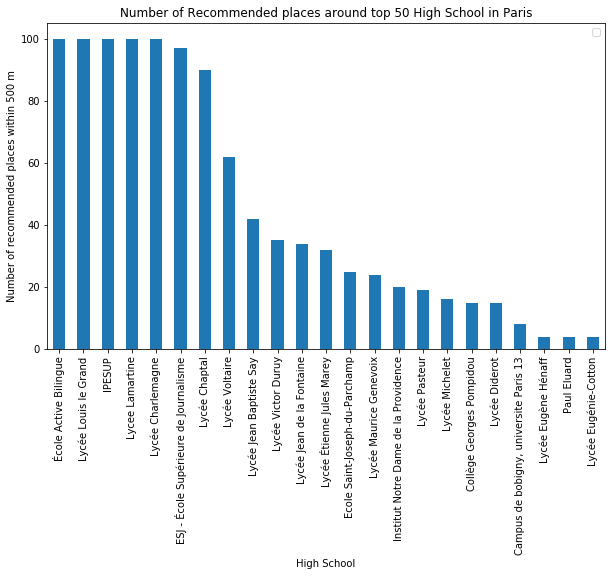

In [26]:
recommended_count_per_HS = paris_highschool_recommended_venues.groupby('High School').count()
recommended_count_per_HS.drop(['High School Longitude','Recommended Place','Recommended Place Latitude','Recommended Place Longitude','Recommended Place Distance','Recommended Place Category'], axis=1, inplace=True)
recommended_count_per_HS.sort_values(['High School Latitude'], ascending=False, axis=0, inplace=True)

# plot data
recommended_count_per_HS.plot(kind='bar', figsize=(10, 6))

plt.xlabel('High School') # add to x-label to the plot
plt.ylabel('Number of recommended places within 500 m') # add y-label to the plot
plt.title('Number of Recommended places around top 50 High School in Paris') # add title to the plot
plt.legend('') # add title to the plot

plt.show()

As you can see on the bar plot above, we can distinguish three categories of High School based on the number of recommended place around.
- More than 40 recommended places
- between 10 and 40 recommended places
- less than 10 recommended places.

This is an indication that these three area may have distinct people visiting it. Maybe it's an indication of the area where there is more Foursquare users? 

#### We can also take a look at the number of High School near each Recommended Place Category.

In order to better visualize these data, we can plot them as a vertical bar plot.

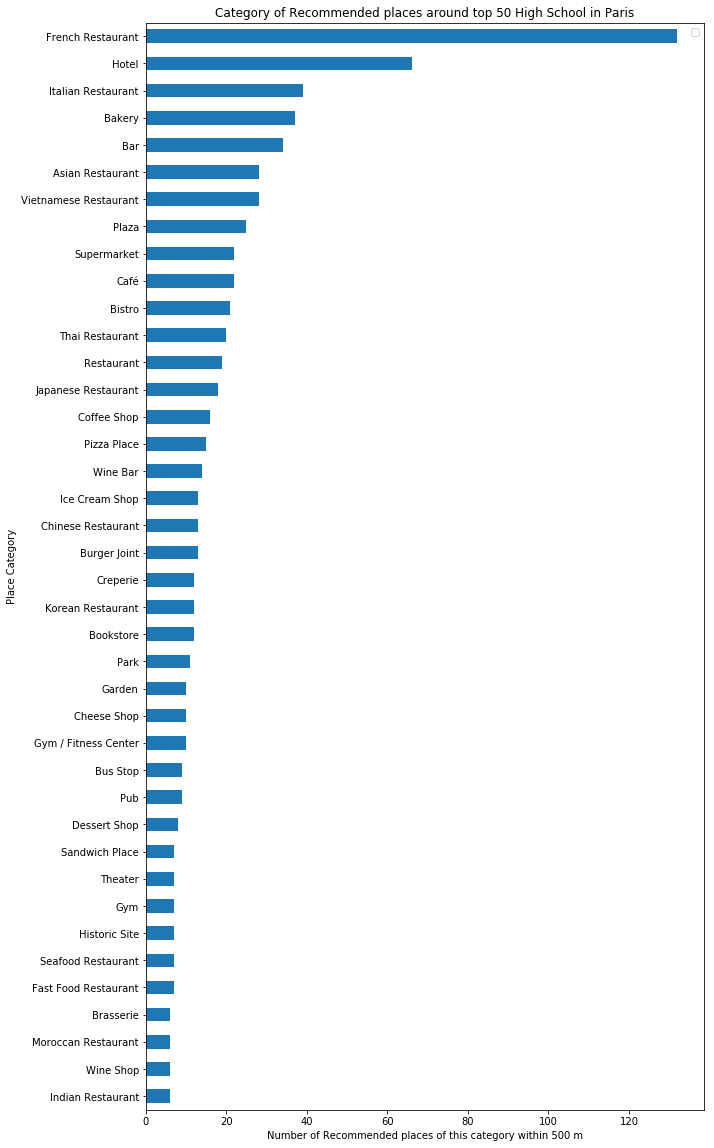

In [27]:
HS_count_per_RecomPlaceCategory = paris_highschool_recommended_venues.groupby('Recommended Place Category').count()
HS_count_per_RecomPlaceCategory.drop(['High School Longitude','Recommended Place','Recommended Place Latitude','Recommended Place Longitude','Recommended Place Distance','High School'], axis=1, inplace=True)
HS_count_per_RecomPlaceCategory.sort_values(['High School Latitude'], ascending=True, axis=0, inplace=True)

# plot data
HS_count_per_RecomPlaceCategory.tail(40).plot(kind='barh', figsize=(10, 20))

plt.xlabel('Number of Recommended places of this category within 500 m') # add to x-label to the plot
plt.ylabel('Place Category') # add y-label to the plot
plt.title('Category of Recommended places around top 50 High School in Paris') # add title to the plot
plt.legend('') # add title to the plot

plt.show()

Unsurprinsingly, the most common category of recommended place within 500 m of High School in Paris are french restaurant by far. The second most common category are hotel which is also not really surprising since Paris is a common touristic destination.

Now, let's focus on specific categories of place: 
- College & University (4d4b7105d754a06372d81259)
- Tech Startup (4bf58dd8d48988d125941735)
- Coworking Space (4bf58dd8d48988d174941735)
- Industrial Estate (56aa371be4b08b9a8d5734d7)
- Laboratory (5744ccdfe4b0c0459246b4d6)
- Library (4bf58dd8d48988d12f941735)
- Research Station (58daa1558bbb0b01f18ec1b2)
- Recruiting Agency (52f2ab2ebcbc57f1066b8b57)
- Financial or Legal Service (503287a291d4c4b30a586d65)
- Lawyer (52f2ab2ebcbc57f1066b8b3f)
- Business Center (56aa371be4b08b9a8d573517)
- Factory (4eb1bea83b7b6f98df247e06)
- Advertising Agency (52e81612bcbc57f1066b7a3d)
- Adult Education Center (56aa371ce4b08b9a8d573570)
- Business Service (5453de49498eade8af355881)
- Design Studio (4bf58dd8d48988d1f4941735)
- Insurance Office (58daa1558bbb0b01f18ec1f1)
- Science Museum (4bf58dd8d48988d191941735)
- Art Museum (4bf58dd8d48988d18f941735)
- History Museum (4bf58dd8d48988d190941735)
- Planetarium (4bf58dd8d48988d192941735)
- Events (4d4b7105d754a06373d81259)

Geo clusters
- City (50aa9e094b90af0d42d5de0d)
- Neighborhood (4f2a25ac4b909258e854f55f)

In [28]:
matt_category_list = pd.read_csv('https://github.com/MattSonnati/Data_Science_Coursera_Capstone/raw/master/matt_category_list.csv')
matt_category_list

,4sq_category_name,4sq_id,color_code
0,Tech Startup,4bf58dd8d48988d125941735,#32CD32
1,Coworking Space,4bf58dd8d48988d174941735,#ADFF2F
2,Insurance Office,58daa1558bbb0b01f18ec1f1,#FFD700
3,Recruiting Agency,52f2ab2ebcbc57f1066b8b57,#FFFFE0
4,Financial or Legal Service,503287a291d4c4b30a586d65,#FFE4B5
5,Lawyer,52f2ab2ebcbc57f1066b8b3f,#FFFF00
6,Laboratory,5744ccdfe4b0c0459246b4d6,#87CEFA
7,College & University,4d4b7105d754a06372d81259,#00BFFF
8,Adult Education Center,56aa371ce4b08b9a8d573570,#6495ED
9,Research Station,58daa1558bbb0b01f18ec1b2,#4169E1


#### What are the top 50 places in the College & University (4d4b7105d754a06372d81259) category in Paris, France (radius 10000 meters)?

In [29]:
#create the GET request URL
radius = 10000
LIMIT = 200
address_near = "Paris, France"
category_id = "4d4b7105d754a06372d81259"

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&v={}&radius={}&limit={}&intent=browse&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    address_near,  
    VERSION, 
    radius, 
    LIMIT,
    category_id)

# Send the GET request 
results = requests.get(url).json()

# Convert the JSON response into a dataframe
coll_univ_paris = results['response']['venues']
coll_univ_paris_list = json_normalize(coll_univ_paris) # flatten JSON

# filter columns
filtered_columns = ['name',
                    'id',
                    'location.address',
                    'location.postalCode',
                    'location.city',
                    'location.state',
                    'location.country',
                    'location.cc',
                    'location.lat', 
                    'location.lng',
                    'categories',]
coll_univ_paris_list =coll_univ_paris_list.loc[:, filtered_columns]

# filter the category for each row
coll_univ_paris_list['primary_category_name'] = coll_univ_paris_list.apply(get_category_name, axis=1)
coll_univ_paris_list['primary_category_id'] = coll_univ_paris_list.apply(get_category_id, axis=1)

# clean columns
coll_univ_paris_list.columns = [col.split(".")[-1] for col in coll_univ_paris_list.columns]

coll_univ_paris_list.head()

,name,id,address,postalCode,city,state,country,cc,lat,lng,categories,primary_category_name,primary_category_id
0,Cours de Civilisation Française de la Sorbonne...,4bb06453f964a520a7433ce3,214 boulevard Raspail,75014,Paris,Île-de-France,France,FR,48.840694,2.329331,"[{'pluralName': 'College Academic Buildings', ...",College Academic Building,4bf58dd8d48988d198941735
1,Conservatoire National des Arts et Métiers (CNAM),4b0ea778f964a5205a5923e3,292 rue Saint-Martin,75003,Paris,Île-de-France,France,FR,48.866922,2.356215,[{'pluralName': 'General Colleges & Universiti...,General College & University,4bf58dd8d48988d1a8941735
2,ESCE,4f635e73e4b04b2442920f4b,10 Rue Sextius Michel,75015,Paris,Île-de-France,France,FR,48.851176,2.288287,"[{'pluralName': 'Trade Schools', 'id': '4bf58d...",Trade School,4bf58dd8d48988d1ad941735
3,Fondation Biermans-Lapôtre,4e9249ed55037de99d58d83a,9A boulevard Jourdan,75014,Paris,Île-de-France,France,FR,48.819442,2.341022,"[{'pluralName': 'College Residence Halls', 'id...",College Residence Hall,4bf58dd8d48988d1a3941735
4,Maison Internationale,4dd6ac2a8877f1150fd69d2e,27 Boulevard Jourdan,75014,Paris,Île-de-France,France,FR,48.819388,2.338156,[{'pluralName': 'General Colleges & Universiti...,General College & University,4bf58dd8d48988d1a8941735


In [30]:
coll_univ_paris_list.shape

(50, 13)

#### What are the top 50 places in the Tech Startup (4bf58dd8d48988d125941735) category in Paris, France (radius 10000 meters)?

In [31]:
#create the GET request URL
radius = 10000
LIMIT = 200
address_near = "Paris, France"
category_id = "4bf58dd8d48988d125941735"

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&v={}&radius={}&limit={}&intent=browse&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    address_near,  
    VERSION, 
    radius, 
    LIMIT,
    category_id)

# Send the GET request 
results = requests.get(url).json()

# Convert the JSON response into a dataframe
tech_startup = results['response']['venues']
tech_startup_list = json_normalize(tech_startup) # flatten JSON

# filter columns
filtered_columns = ['name',
                    'id',
                    'location.address',
                    'location.postalCode',
                    'location.city',
                    'location.state',
                    'location.country',
                    'location.cc',
                    'location.lat', 
                    'location.lng',
                    'categories',]
tech_startup_list =tech_startup_list.loc[:, filtered_columns]

# filter the category for each row
tech_startup_list['primary_category_name'] = tech_startup_list.apply(get_category_name, axis=1)
tech_startup_list['primary_category_id'] = tech_startup_list.apply(get_category_id, axis=1)

# clean columns
tech_startup_list.columns = [col.split(".")[-1] for col in tech_startup_list.columns]

tech_startup_list.head()

,name,id,address,postalCode,city,state,country,cc,lat,lng,categories,primary_category_name,primary_category_id
0,Qonto HQ,58a16c5f51d19e06ce98f38d,8 rue du Sentier,75003,Paris,Île-de-France,France,FR,48.868517,2.345687,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",Tech Startup,4bf58dd8d48988d125941735
1,Salesforce France,4dac5df543a112819724533f,3 avenue Octave Gréard,75007,Paris,Île-de-France,France,FR,48.856391,2.293381,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",Tech Startup,4bf58dd8d48988d125941735
2,Algolia,59f711f53d4791157b9e7f62,55 rue d'Amsterdam,75008,Paris,Île-de-France,France,FR,48.880447,2.327044,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",Tech Startup,4bf58dd8d48988d125941735
3,Criteo,4fdee1f3e4b014c45c45905c,32 rue Blanche,75009,Paris,Île-de-France,France,FR,48.879049,2.332151,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",Tech Startup,4bf58dd8d48988d125941735
4,Amazon France,5162932ae4b0806917113bbd,67 boulevard du General Leclerc,92110,Clichy,Île-de-France,France,FR,48.903978,2.311060,"[{'pluralName': 'Offices', 'id': '4bf58dd8d489...",Office,4bf58dd8d48988d124941735


In [32]:
tech_startup_list.shape

(50, 13)

#### What are the top 50 places in the Coworking Space (4bf58dd8d48988d174941735) category in Paris, France (radius 10000 meters)?

In [33]:
#create the GET request URL
radius = 10000
LIMIT = 200
address_near = "Paris, France"
category_id = "4bf58dd8d48988d174941735"

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&v={}&radius={}&limit={}&intent=browse&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    address_near,  
    VERSION, 
    radius, 
    LIMIT,
    category_id)

# Send the GET request 
results = requests.get(url).json()

# Convert the JSON response into a dataframe
coworking = results['response']['venues']
coworking_list = json_normalize(coworking) # flatten JSON

# filter columns
filtered_columns = ['name',
                    'id',
                    'location.address',
                    'location.postalCode',
                    'location.city',
                    'location.state',
                    'location.country',
                    'location.cc',
                    'location.lat', 
                    'location.lng',
                    'categories',]
coworking_list =coworking_list.loc[:, filtered_columns]

# filter the category for each row
coworking_list['primary_category_name'] = coworking_list.apply(get_category_name, axis=1)
coworking_list['primary_category_id'] = coworking_list.apply(get_category_id, axis=1)

# clean columns
coworking_list.columns = [col.split(".")[-1] for col in coworking_list.columns]

coworking_list.head()

,name,id,address,postalCode,city,state,country,cc,lat,lng,categories,primary_category_name,primary_category_id
0,Station F,5818904338fa7f7b5434dc4d,55 boulevard Vincent Auriol,75013,Paris,Île-de-France,France,FR,48.833396,2.371759,"[{'pluralName': 'Coworking Spaces', 'id': '4bf...",Coworking Space,4bf58dd8d48988d174941735
1,Webedia,4c893b24ed0aa1439c0bb0f3,2 rue Paul Vaillant Couturier,92300,Levallois-Perret,Île-de-France,France,FR,48.893556,2.277594,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",Tech Startup,4bf58dd8d48988d125941735
2,Thales Digital Factory,5959e765b1538e23f9ac9f25,Rue Lafayette 33,75009,Paris,Île-de-France,France,FR,48.874677,2.338054,"[{'pluralName': 'Coworking Spaces', 'id': '4bf...",Coworking Space,4bf58dd8d48988d174941735
3,PRINE (Paris Région Innovation Nord Express),4ed8a6be7ee506bd29ab459a,46 rue René Clair,75018,Paris,Île-de-France,France,FR,48.893980,2.354337,"[{'pluralName': 'Coworking Spaces', 'id': '4bf...",Coworking Space,4bf58dd8d48988d174941735
4,Anticafé Station F,595cdcb8c365882ea4130a8c,Station F,75013,Paris,Île-de-France,France,FR,48.834487,2.370453,"[{'pluralName': 'Coffee Shops', 'id': '4bf58dd...",Coffee Shop,4bf58dd8d48988d1e0931735


In [34]:
coworking_list.shape

(50, 13)

#### What are the City (50aa9e094b90af0d42d5de0d) in Paris, France (radius 10000 meters)?

In [35]:
#create the GET request URL
radius = 10000
LIMIT = 200
address_near = "Paris, France"
category_id = "50aa9e094b90af0d42d5de0d"

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&v={}&radius={}&limit={}&intent=browse&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    address_near,  
    VERSION, 
    radius, 
    LIMIT,
    category_id)

# Send the GET request 
results = requests.get(url).json()

# Convert the JSON response into a dataframe
cities_paris = results['response']['venues']
cities_paris_list = json_normalize(cities_paris) # flatten JSON

# filter columns
filtered_columns = ['name',
                    'id',
                    'location.postalCode',
                    'location.state',
                    'location.country',
                    'location.cc',
                    'location.lat', 
                    'location.lng',
                    'categories',]
cities_paris_list =cities_paris_list.loc[:, filtered_columns]

# filter the category for each row
cities_paris_list['primary_category_name'] = cities_paris_list.apply(get_category_name, axis=1)
cities_paris_list['primary_category_id'] = cities_paris_list.apply(get_category_id, axis=1)

# clean columns
cities_paris_list.columns = [col.split(".")[-1] for col in cities_paris_list.columns]

cities_paris_list.head()

,name,id,postalCode,state,country,cc,lat,lng,categories,primary_category_name,primary_category_id
0,Paris,50dbd18d498eb594ef575b0a,75000,Île-de-France,France,FR,48.857006,2.351490,"[{'pluralName': 'Cities', 'id': '50aa9e094b90a...",City,50aa9e094b90af0d42d5de0d
1,Levallois-Perret,4ccc49e754f0b1f79d4515ca,92300,Île-de-France,France,FR,48.893985,2.288295,"[{'pluralName': 'Cities', 'id': '50aa9e094b90a...",City,50aa9e094b90af0d42d5de0d
2,Neuilly-sur-Seine,509f8996e4b05e06b5811a17,92200,Île-de-France,France,FR,48.884924,2.269471,"[{'pluralName': 'Cities', 'id': '50aa9e094b90a...",City,50aa9e094b90af0d42d5de0d
3,Boulogne-Billancourt,4c80bf1e74d7b60c080670d8,92100,Île-de-France,France,FR,48.834141,2.242686,"[{'pluralName': 'Cities', 'id': '50aa9e094b90a...",City,50aa9e094b90af0d42d5de0d
4,Suresnes,4ba873c0f964a5209ddb39e3,92150,Île-de-France,France,FR,48.870775,2.224048,"[{'pluralName': 'Cities', 'id': '50aa9e094b90a...",City,50aa9e094b90af0d42d5de0d


In [36]:
cities_paris_list.shape

(41, 11)

In [37]:
# create a user agent
geolocator = Nominatim(user_agent="fr_explorer")

address = 'Paris, France'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name, postalCode  in zip(cities_paris_list['lat'], 
                                                      cities_paris_list['lng'], 
                                                      cities_paris_list['name'], 
                                                      cities_paris_list['postalCode']):
    label = '{} {}'.format(name, postalCode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

#### Get all the Neighborhood (4f2a25ac4b909258e854f55f) within 5000m of the cities within 10000 meters of Paris, France

In [38]:
def getCategoryVenues(name, latitude, longitude, radius, category_id):
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&intent=browse&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    latitude, 
    longitude, 
    VERSION,
    radius, 
    LIMIT,
    category_id)

    # Send the GET request 
    results = requests.get(url).json()

    # Convert the JSON response into a dataframe
    category_venues = results['response']['venues']
    category_venues_list = json_normalize(category_venues) # flatten JSON

    # filter columns
    filtered_columns = ['name',
                            'id',
                            'location.postalCode',
                            'location.state',
                            'location.country',
                            'location.cc',
                            'location.lat', 
                            'location.lng',
                            'categories',]
    category_venues_list = category_venues_list.loc[:, filtered_columns]

    # filter the category for each row
    category_venues_list['primary_category_name'] = category_venues_list.apply(get_category_name, axis=1)
    category_venues_list['primary_category_id'] = category_venues_list.apply(get_category_id, axis=1)

    # clean columns
    category_venues_list.columns = [col.split(".")[-1] for col in category_venues_list.columns]

    return(category_venues_list)
    

def getMap(venues_list):

    # create a user agent
    geolocator = Nominatim(user_agent="fr_explorer")

    address = 'Paris, France'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude

    # create map using latitude and longitude values
    map_venues = folium.Map(location=[latitude, longitude], zoom_start=12)

    # add markers to map
    for lat, lng, name, postalCode  in zip(venues_list['lat'], 
                                                          venues_list['lng'], 
                                                          venues_list['name'], 
                                                          venues_list['postalCode']):
        label = '{} {}'.format(name, postalCode)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_venues)  

    return(map_venues)

In [39]:
neighborhood_paris_list = getCategoryVenues('Paris', 48.857006, 2.351490, 5000, '4f2a25ac4b909258e854f55f')
neighborhood_paris_list.head()

,name,id,postalCode,state,country,cc,lat,lng,categories,primary_category_name,primary_category_id
0,Montmartre,4c68251df984a593a80b49f4,75018,Île-de-France,France,FR,48.886942,2.341526,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",Neighborhood,4f2a25ac4b909258e854f55f
1,Le Marais,4c2f45ff16adc928bc34bd9c,75004,Île-de-France,France,FR,48.857880,2.355108,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",Neighborhood,4f2a25ac4b909258e854f55f
2,Les Halles,5314c230e4b0d805d37ba357,NaN,Île-de-France,France,FR,48.861618,2.346719,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",Neighborhood,4f2a25ac4b909258e854f55f
3,Belleville,4e3f1aa31495bf24a5f14f43,75020,Île-de-France,France,FR,48.873415,2.378543,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",Neighborhood,4f2a25ac4b909258e854f55f
4,Quartier Latin,4adcda0af964a520523421e3,75005,Île-de-France,France,FR,48.851664,2.343552,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",Neighborhood,4f2a25ac4b909258e854f55f


In [40]:
neighborhood_paris_list.shape

(43, 11)

In [41]:
radius = 5000
category_id = '4f2a25ac4b909258e854f55f'
neighborhoods_paris_list = pd.DataFrame(columns=['name','id','city','postalCode','state','country','cc','lat','lng','categoriesList','primary_category_name','primary_category_id'])

for latitude, longitude, name  in zip(cities_paris_list['lat'],
                                      cities_paris_list['lng'],
                                      cities_paris_list['name']):
    
    neighborhoods_paris_list = pd.concat([neighborhoods_paris_list, getCategoryVenues(name, latitude, longitude, radius, category_id)])    

neighborhoods_paris_list.head()

,categories,categoriesList,cc,city,country,id,lat,lng,name,postalCode,primary_category_id,primary_category_name,state
0,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,4c68251df984a593a80b49f4,48.886942,2.341526,Montmartre,75018,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France
1,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,4c2f45ff16adc928bc34bd9c,48.857880,2.355108,Le Marais,75004,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France
2,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,5314c230e4b0d805d37ba357,48.861618,2.346719,Les Halles,NaN,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France
3,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,4e3f1aa31495bf24a5f14f43,48.873415,2.378543,Belleville,75020,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France
4,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,4adcda0af964a520523421e3,48.851664,2.343552,Quartier Latin,75005,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France


In [42]:
neighborhoods_paris_list.shape

(963, 13)

In [43]:
neighborhoods_paris_list.tail(100)

,categories,categoriesList,cc,city,country,id,lat,lng,name,postalCode,primary_category_id,primary_category_name,state
9,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,5801f59938fa3dc51095c39c,48.793307,2.259223,Jardin Parisien - Clamart,NaN,4f2a25ac4b909258e854f55f,Neighborhood,NaN
10,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,4fe4bdace4b0474e67fea6c9,48.819455,2.289079,Le Banc,NaN,4f2a25ac4b909258e854f55f,Neighborhood,NaN
11,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,543bcbd8498e5b5416e94ac5,48.806807,2.241576,Val-Fleury,NaN,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France
12,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,4faa369fe4b0d41a2f8331ab,48.767607,2.279873,Centre-Ville de Châtenay-Malabry,92290,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France
13,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,5305b86c498e84f858d6337d,48.780853,2.301698,Les Bas Coudrais,NaN,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France
14,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,5a15a8b750a6f057570f8caf,48.779337,2.257304,Cité Jardin,92350,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France
15,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,55d26492498e761676bac707,48.838027,2.300600,Quartier Saint-Lambert,75015,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France
16,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,5218af2e11d2df8d7dda110e,48.840011,2.261078,Villa Dietz-Monin,NaN,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France
17,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,51114f52e4b0ed5bb79ec30e,48.820129,2.229607,Bellevue,NaN,4f2a25ac4b909258e854f55f,Neighborhood,NaN
18,"[{'pluralName': 'Neighborhoods', 'id': '4f2a25...",NaN,FR,NaN,France,50f6ccc9e4b08f926847fbcb,48.821530,2.257126,Lartigue,NaN,4f2a25ac4b909258e854f55f,Neighborhood,Île-de-France


In [44]:
 getMap(neighborhoods_paris_list)

In [51]:
radius = 5000
matt_paris_list = pd.DataFrame(columns=['name','id','city','postalCode','state','country','cc','lat','lng','categoriesList','primary_category_name','primary_category_id','matt_category_name','matt_category_id','matt_category_color'])

for category_name, category_id, color_code  in zip(matt_category_list['4sq_category_name'],
                                          matt_category_list['4sq_id'],
                                          matt_category_list['color_code']):
   
    for latitude, longitude, name  in zip(cities_paris_list['lat'],
                                          cities_paris_list['lng'],
                                          cities_paris_list['name']):
        try:
            matt_paris_list = pd.concat([matt_paris_list, getCategoryVenues(name, latitude, longitude, radius, category_id)])
        except:
            pass

matt_paris_list.drop_duplicates(subset=['id'], keep='first', inplace=True)
matt_paris_list.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,categories,categoriesList,cc,city,country,id,lat,lng,matt_category_color,matt_category_id,matt_category_name,name,postalCode,primary_category_id,primary_category_name,state
0,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,58a16c5f51d19e06ce98f38d,48.868517,2.345687,NaN,NaN,NaN,Qonto HQ,75003,4bf58dd8d48988d125941735,Tech Startup,Île-de-France
1,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,4dac5df543a112819724533f,48.856391,2.293381,NaN,NaN,NaN,Salesforce France,75007,4bf58dd8d48988d125941735,Tech Startup,Île-de-France
2,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,59f711f53d4791157b9e7f62,48.880447,2.327044,NaN,NaN,NaN,Algolia,75008,4bf58dd8d48988d125941735,Tech Startup,Île-de-France
3,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,4fdee1f3e4b014c45c45905c,48.879049,2.332151,NaN,NaN,NaN,Criteo,75009,4bf58dd8d48988d125941735,Tech Startup,Île-de-France
4,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,59e9b4ec3abcaf334aa66d07,48.872823,2.350290,NaN,NaN,NaN,Spendesk HQ,75010,4bf58dd8d48988d125941735,Tech Startup,Île-de-France


In [52]:
matt_paris_list.drop_duplicates(subset=['id'], keep='first', inplace=True)
matt_paris_list.head(50)

,categories,categoriesList,cc,city,country,id,lat,lng,matt_category_color,matt_category_id,matt_category_name,name,postalCode,primary_category_id,primary_category_name,state
0,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,58a16c5f51d19e06ce98f38d,48.868517,2.345687,NaN,NaN,NaN,Qonto HQ,75003,4bf58dd8d48988d125941735,Tech Startup,Île-de-France
1,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,4dac5df543a112819724533f,48.856391,2.293381,NaN,NaN,NaN,Salesforce France,75007,4bf58dd8d48988d125941735,Tech Startup,Île-de-France
2,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,59f711f53d4791157b9e7f62,48.880447,2.327044,NaN,NaN,NaN,Algolia,75008,4bf58dd8d48988d125941735,Tech Startup,Île-de-France
3,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,4fdee1f3e4b014c45c45905c,48.879049,2.332151,NaN,NaN,NaN,Criteo,75009,4bf58dd8d48988d125941735,Tech Startup,Île-de-France
4,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,59e9b4ec3abcaf334aa66d07,48.872823,2.350290,NaN,NaN,NaN,Spendesk HQ,75010,4bf58dd8d48988d125941735,Tech Startup,Île-de-France
5,"[{'pluralName': 'Schools', 'id': '4bf58dd8d489...",NaN,FR,NaN,France,5ac8cf0c6bd36b7f1acf9078,48.871718,2.311018,NaN,NaN,NaN,Ironhack,75008,4bf58dd8d48988d13b941735,School,Île-de-France
6,"[{'pluralName': 'Coworking Spaces', 'id': '4bf...",NaN,FR,NaN,France,5959e765b1538e23f9ac9f25,48.874677,2.338054,NaN,NaN,NaN,Thales Digital Factory,75009,4bf58dd8d48988d174941735,Coworking Space,Île-de-France
7,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,5afab1c18c812a002c869914,48.854006,2.373154,NaN,NaN,NaN,Zenly HQ,75011,4bf58dd8d48988d125941735,Tech Startup,Île-de-France
8,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,531b1aad498ea3dcb5b55666,48.852861,2.364293,NaN,NaN,NaN,TheFamily,75004,4bf58dd8d48988d125941735,Tech Startup,Île-de-France
9,"[{'pluralName': 'Tech Startups', 'id': '4bf58d...",NaN,FR,NaN,France,4b26b6fcf964a520ed7f24e3,48.869372,2.347344,NaN,NaN,NaN,af83,75002,4bf58dd8d48988d125941735,Tech Startup,Île-de-France


In [53]:
matt_paris_list.shape

(4938, 16)

In [48]:
 getMap(matt_paris_list.head(500))

#### We can take a look at the number of of place in each categories.

In order to better visualize these data, we can plot them as a horizontal bar plot.

In [66]:
paris_count_per_category = matt_paris_list.groupby('primary_category_name').count()
paris_count_per_category.drop(['categories','categoriesList','state','postalCode','matt_category_name','matt_category_id','matt_category_color','city'], axis=1, inplace=True)
paris_count_per_category.sort_values(['id'], ascending=True, axis=0, inplace=True)
paris_count_per_category

,cc,country,id,lat,lng,name,primary_category_id
primary_category_name,,,,,,,
Accessories Store,1,1,1,1,1,1,1
Jewelry Store,1,1,1,1,1,1,1
Hotel,1,1,1,1,1,1,1
Health & Beauty Service,1,1,1,1,1,1,1
Gym,1,1,1,1,1,1,1
Garden,1,1,1,1,1,1,1
French Restaurant,1,1,1,1,1,1,1
Waste Facility,1,1,1,1,1,1,1
Festival,1,1,1,1,1,1,1


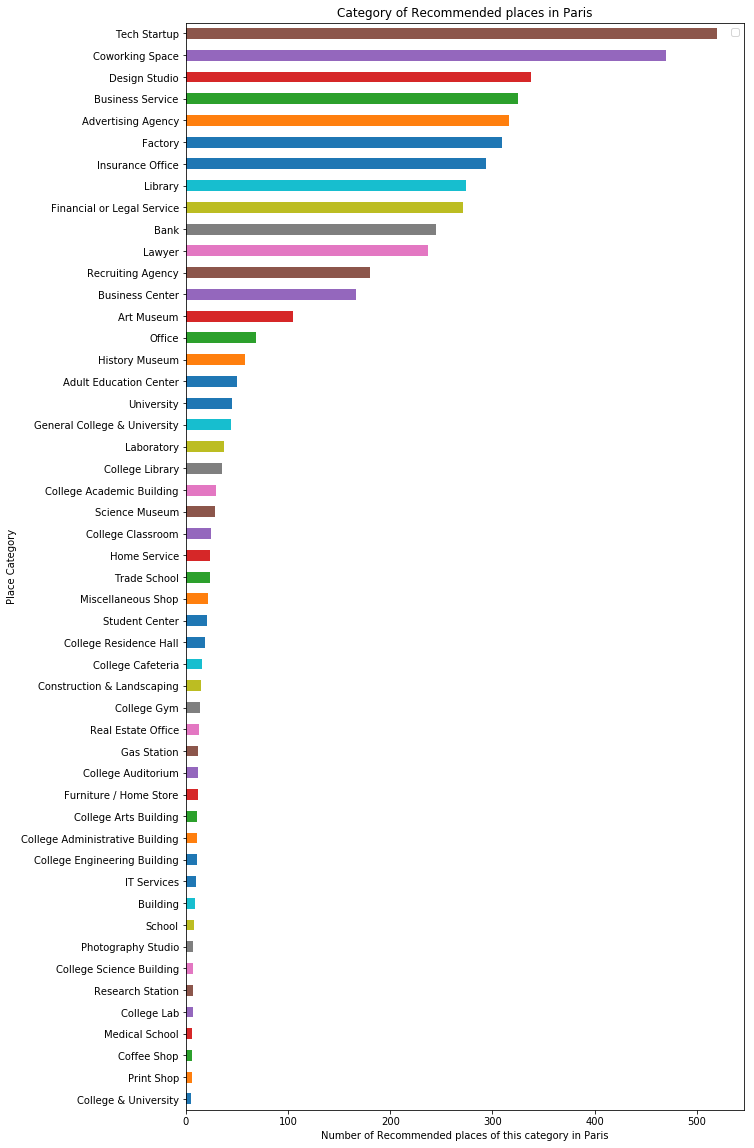

In [67]:
# plot data
paris_count_per_category['id'].tail(50).plot(kind='barh', figsize=(10, 20))

plt.xlabel('Number of Recommended places of this category in Paris') # add to x-label to the plot
plt.ylabel('Place Category') # add y-label to the plot
plt.title('Category of Recommended places in Paris') # add title to the plot
plt.legend('') # add title to the plot

plt.show()

## 2. Data Understanding

## 3. Data Visualization